In [1]:
import matplotlib.pyplot as pl
import matplotlib
import numpy as np

#Plotting parameters
font={'family':'Times New Roman', 'size':23}	
matplotlib.rc('font', **font)
matplotlib.rc('axes', linewidth=2)
matplotlib.rc('xtick.major', width=2, size=8)
matplotlib.rc('xtick.minor', width=2, size=4)
matplotlib.rc('ytick.major', width=2, size=8)
matplotlib.rc('ytick.minor', width=2, size=4)
matplotlib.rc('xtick', labelsize=20)
matplotlib.rc('ytick', labelsize=20)
matplotlib.rcParams.update({'figure.autolayout': True})

In [2]:
#Read stellar file, input parameters
starfluxfilename='../files/bPic_starfluxJyfromEarth_ext.npy'
wavuvum, fluxuvJy=np.load(starfluxfilename)
distpc=19.44
fluxuvSI1AU=fluxuvJy*1e-26*((distpc*2.0626*1e5)**2.0)#/1000.0
distau=85.0
fluxuvSIat85au=fluxuvSI1AU/(distau**2.0)
fluxuvJyat85au=fluxuvSIat85au*1e26
#print(len(wavuvum))

In [3]:
#Calculate CMB radiation field
T_cmb=2.72548 #temperature of CMB
F_cmb=2.*6.626e-34*((2.9979e8/(wavuvum/1e6))**3.0)/(((2.9979e8)**2.0)*(np.exp(6.626e-34*(2.9979e8/(wavuvum/1e6))/(1.38e-23*T_cmb))-1.)) #Bnu(CMB)
F_cmb*=1e26*4.*np.pi#turn to flux in Jy

/tmp/ipykernel_2739448/268083718.py:3: RuntimeWarning: overflow encountered in exp
  F_cmb=2.*6.626e-34*((2.9979e8/(wavuvum/1e6))**3.0)/(((2.9979e8)**2.0)*(np.exp(6.626e-34*(2.9979e8/(wavuvum/1e6))/(1.38e-23*T_cmb))-1.)) #Bnu(CMB)
/tmp/ipykernel_2739448/268083718.py:3: RuntimeWarning: overflow encountered in multiply
  F_cmb=2.*6.626e-34*((2.9979e8/(wavuvum/1e6))**3.0)/(((2.9979e8)**2.0)*(np.exp(6.626e-34*(2.9979e8/(wavuvum/1e6))/(1.38e-23*T_cmb))-1.)) #Bnu(CMB)


In [4]:
#Read interstellar Draine field flux file
rfile = open('../files/ISRF.dat', 'r')
dum=rfile.readline()
dum=rfile.readline()
dum=rfile.readline()
dum=rfile.readline()
nlinesisrf=1909
wavisrfnm=np.zeros(nlinesisrf)
fluxisrfweird=np.zeros(nlinesisrf)
#Read wavelengths in nm and fluxes in photons cm^-2 s^-1 nm^-1
for i in np.arange(nlinesisrf):
	wavisrfnm[i], fluxisrfweird[i] = rfile.readline().split()
wavisrfang=wavisrfnm*10.0
fluxisrf=fluxisrfweird/10.0 # Now in photons cm^-2 s^-1 A^-1
#print wavisrfang.min(), wavisrfang.max()
#print wavcrsectang.min(), wavcrsectang.max()
fluxisrfjy=fluxisrf*6.63e-4*wavisrfang

In [5]:
#Read dust continuum mean intensity file (from RADMC-3D calculation based on model 3 of Matra et al. 2019, with dust SED shape calculated based on modified blackbody SED best fit from Matra et al. 2025)
#This is the maximum continuum radiation field in the disk, so the one felt by a gas species in the midplane, at ~90 au.
data=np.loadtxt('../files/maxmeanintdust_vs_wav.txt', delimiter=' ', skiprows=1)
w=data[:,0]
meanintvswav=data[:,1]
#Turn from mean intensity to flux by multiplying by 4pi, and go from cgs units to Jy
fluxdust=meanintvswav*4*np.pi*1e23

In [6]:
#Read in CO uv line wavelengths for overplotting
datafile='../files/COvibrot_Lambda_nelec2_nvib9_nrot30.dat_corrected.dat'
### Read in line transition data 
fname=datafile
#fname='COvibrot_Lambda_nelec2_nvib9_nrot30.dat'
#fname='COrotonly.dat'
try:
	rfile = open(fname, 'r')
except:
	print('Error!') 
	print('Excitation file was not found!')
	sys.exit() 
allfilelines=rfile.readlines() 	
rfile.close()
rfile = open(fname, 'r')

### Read energy levels with quantum numbers
dum=rfile.readline()
species=rfile.readline().split()[0]
dum=rfile.readline()
mwt=float(rfile.readline().split()[0])
dum=rfile.readline()
n_levels=int(rfile.readline().split()[0])
dum=rfile.readline()

levid=np.zeros(n_levels, dtype=int)
energycmmin1=np.zeros(n_levels, dtype=float)
wt=np.zeros(n_levels, dtype=float)
qnel=np.zeros(n_levels, dtype=int)
qnvib=np.zeros(n_levels, dtype=int)
qnrot=np.zeros(n_levels, dtype=int)

for i in np.arange(n_levels):
	levid[i], energycmmin1[i], wt[i], qnel[i], qnvib[i], qnrot[i] = rfile.readline().split()
	#levid[i], energycmmin1[i], wt[i], qnrot[i] = rfile.readline().split()    #If using rotational transitions only

In [7]:
### Read radiative transition data
dum=rfile.readline()
ntr=int(rfile.readline().split()[0])	
dum=rfile.readline()

trid=np.zeros(ntr, dtype=int)
levup=np.zeros(ntr, dtype=int)
levdwn=np.zeros(ntr, dtype=int)
einstA=np.zeros(ntr, dtype=float)
freqghz=np.zeros(ntr, dtype=float)
eupink=np.zeros(ntr, dtype=float)

for i in np.arange(ntr):
	trid[i], levup[i], levdwn[i], einstA[i], freqghz[i], eupink[i] = rfile.readline().split()
rfile.close()

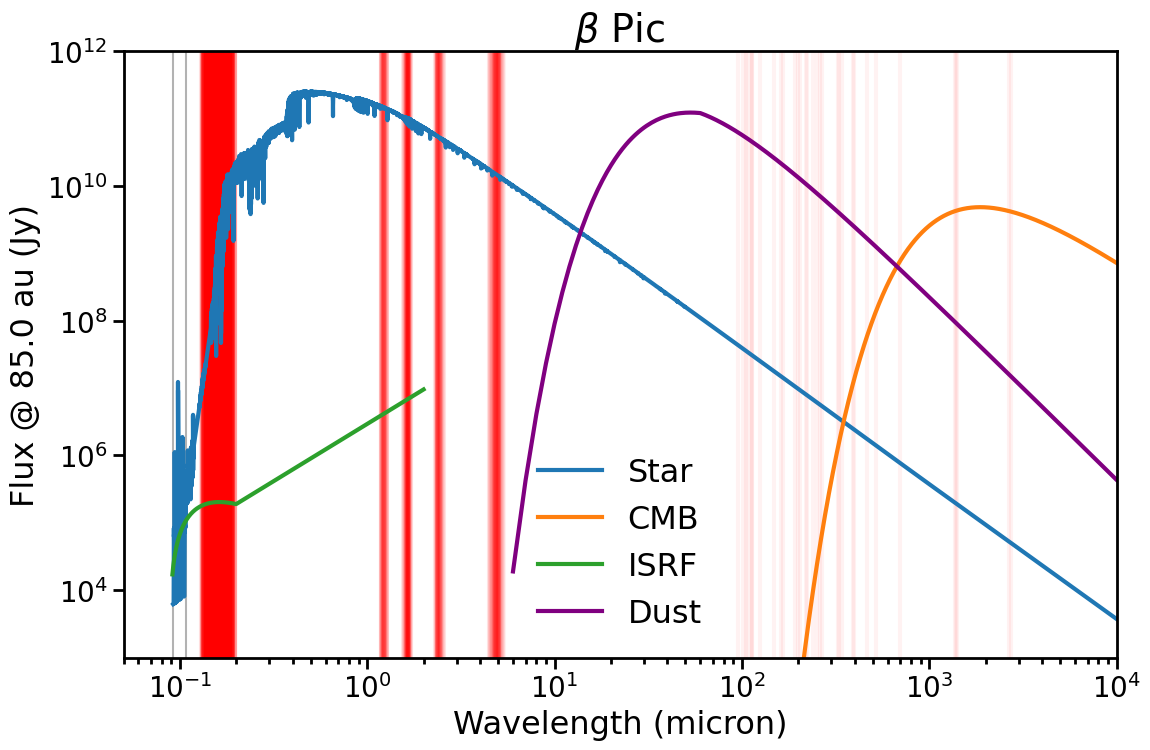

In [16]:
#Now plot it all
#%matplotlib
pl.figure(figsize=(12,8))
#Choose random 100 frequency so as to not plot them all
randfreq=np.random.choice(freqghz, 1000)
for i in np.arange(1000):
	pl.axvline(2.9979e8/(randfreq[i]*1e9)*1e6, alpha=0.05, color='red', lw=3.0)
pl.axvline(920e-4, alpha=0.3, color='black')
pl.axvline(1080e-4, alpha=0.3, color='black')
pl.plot(wavuvum, fluxuvJyat85au, label='Star', lw=3.0)
pl.plot(wavuvum, F_cmb, label='CMB', lw=3.0)
pl.plot(wavisrfang*1e-4, fluxisrfjy, label='ISRF', lw=3.0)
pl.plot(w,fluxdust, label='Dust', color='purple', lw=3.0)
pl.xscale('log')
pl.yscale('log')
pl.ylim(1e3,1e12)
pl.xlim(5e-2,1e4)
pl.xlabel('Wavelength (micron)')
pl.ylabel('Flux @ '+str(distau)+' au (Jy)')
ax=pl.gca()
#pl.text(0.68,0.88, r'$\beta$ Pic', transform=ax.transAxes, fontsize=22)
pl.title(r'$\beta$ Pic')
pl.legend(frameon=False)
#pl.savefig('Radiationfields_betaPic_85au.pdf')
#pl.close()
